ADF Statistic: -4.424951605714015
p-value: 0.0002680629728011447
The series is stationary.
Overall Sales Accuracy:
MAE: 24118.659619733047, RMSE: 27861.754515839613


C:\Users\puroh\AppData\Local\Temp\ipykernel_17856\4162743730.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').sum()
C:\Users\puroh\AppData\Local\Temp\ipykernel_17856\4162743730.py:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(data.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='orange')


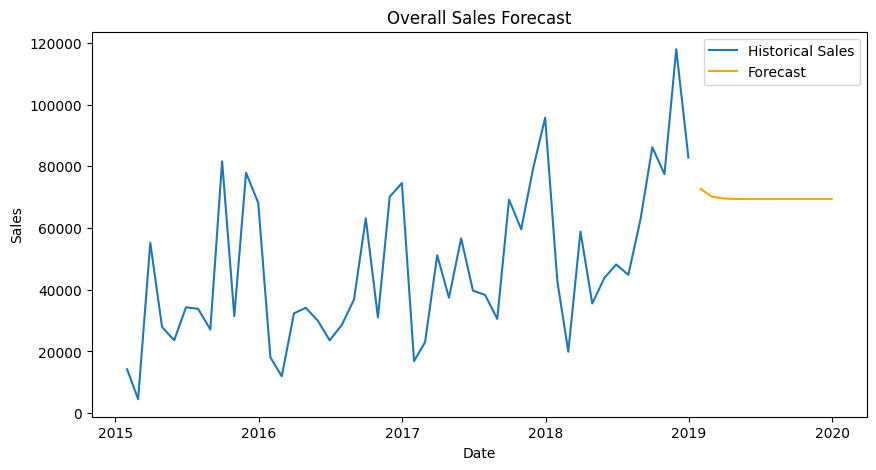

C:\Users\puroh\AppData\Local\Temp\ipykernel_17856\4162743730.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').sum()
C:\Users\puroh\AppData\Local\Temp\ipykernel_17856\4162743730.py:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(data.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='orange')


ADF Statistic: -6.955365792965831
p-value: 9.45931796645293e-10
The series is stationary.
South - Technology Accuracy:
MAE: 348.98060129262393, RMSE: 386.63404159592585


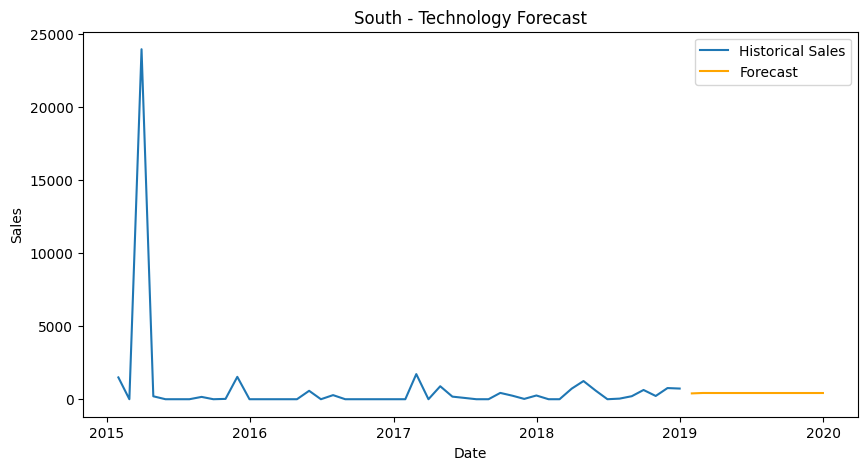

ADF Statistic: -4.7335318535325195
p-value: 7.275829844875449e-05
The series is stationary.
West - Office Supplies Accuracy:
MAE: 1311.9081266526912, RMSE: 1908.944754584882


C:\Users\puroh\AppData\Local\Temp\ipykernel_17856\4162743730.py:57: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.resample('M').sum()
C:\Users\puroh\AppData\Local\Temp\ipykernel_17856\4162743730.py:75: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(data.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='orange')


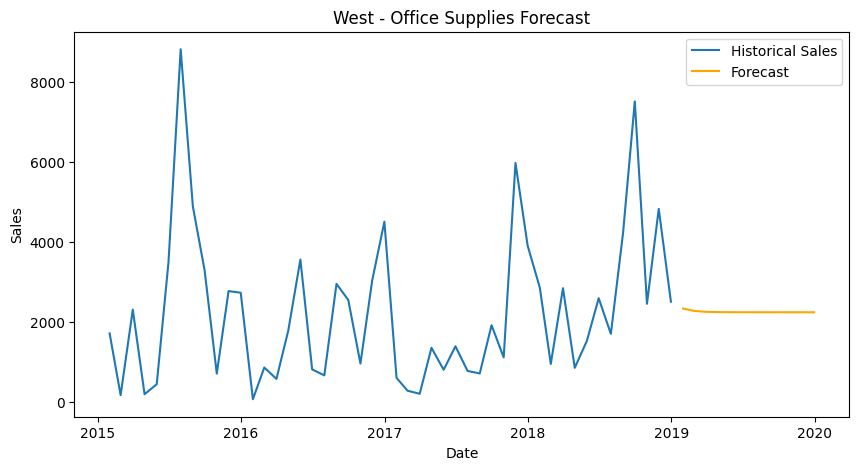

The South - Technology variation has the lowest MAE.
The South - Technology variation has the lowest RMSE.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the data
file_path = r'data\super_store.csv'  # Adjust the file path if necessary
store_data = pd.read_csv(file_path)

# Preprocessing
def preprocess_data(data):
    data['Order Date'] = pd.to_datetime(data['Order Date'], format="%d/%m/%Y")  # Ensure 'Order Date' column is datetime
    data.set_index('Order Date', inplace=True)  # Set 'Order Date' as index
    data = data.sort_index()  # Ensure data is sorted by date
    data = data.dropna()  # Drop missing values
    return data

store_data = preprocess_data(store_data)
# ADF Test for stationarity
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] > 0.05:
        print("The series is non-stationary.")
    else:
        print("The series is stationary.")

# Differencing if necessary
def difference_data(data):
    data['Sales_diff'] = data['Sales'].diff().dropna()
    return data.dropna()

# Function to normalize data
def normalize_data(data, column):
    scaler = MinMaxScaler()
    data[column] = scaler.fit_transform(data[[column]])
    return data, scaler

# Function to fit ARIMA and forecast
def fit_arima_forecast(data, order, steps):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return model_fit, forecast

# Function to calculate accuracy
def calculate_accuracy(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    return mae, rmse

# Function to process, normalize, and forecast for a single variation
def process_and_forecast(data, title):
    data = data.resample('M').sum()
    data, scaler = normalize_data(data, 'Sales')
    adf_test(data['Sales'])

    if adfuller(data['Sales'])[1] > 0.05:
        data = difference_data(data)

    model, forecast = fit_arima_forecast(data['Sales'], (1, 1, 1), 12)
    forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()  # De-normalize forecast
    actual = scaler.inverse_transform(data['Sales'][-12:].values.reshape(-1, 1)).flatten()  # De-normalize actual

    mae, rmse = calculate_accuracy(actual, forecast)

    print(f"{title} Accuracy:")
    print(f"MAE: {mae}, RMSE: {rmse}")

    plt.figure(figsize=(10, 5))
    plt.plot(data.index, scaler.inverse_transform(data['Sales'].values.reshape(-1, 1)), label='Historical Sales')
    plt.plot(pd.date_range(data.index[-1], periods=13, freq='M')[1:], forecast, label='Forecast', color='orange')
    plt.title(f'{title} Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

    return mae, rmse

# 1. Overall Sales Forecast
overall_data = store_data.copy()
mae_overall, rmse_overall = process_and_forecast(overall_data, 'Overall Sales')

# 2. South - Technology Forecast
south_tech_data = store_data[(store_data['Region'] == 'South') & 
                             (store_data['Segment'] == 'Home Office') & 
                             (store_data['Category'] == 'Technology')]
mae_south_tech, rmse_south_tech = process_and_forecast(south_tech_data, 'South - Technology')

# 3. West - Office Supplies Forecast
west_office_supplies_data = store_data[(store_data['Region'] == 'West') & 
                                       (store_data['Segment'] == 'Consumer') & 
                                       (store_data['Category'] == 'Office Supplies')]
mae_west_office, rmse_west_office = process_and_forecast(west_office_supplies_data, 'West - Office Supplies')

# Identify the variation with the lowest error
lowest_mae = min(mae_overall, mae_south_tech, mae_west_office)
lowest_rmse = min(rmse_overall, rmse_south_tech, rmse_west_office)

if lowest_mae == mae_overall:
    print("The Overall Sales variation has the lowest MAE.")
elif lowest_mae == mae_south_tech:
    print("The South - Technology variation has the lowest MAE.")
elif lowest_mae == mae_west_office:
    print("The West - Office Supplies variation has the lowest MAE.")

if lowest_rmse == rmse_overall:
    print("The Overall Sales variation has the lowest RMSE.")
elif lowest_rmse == rmse_south_tech:
    print("The South - Technology variation has the lowest RMSE.")
elif lowest_rmse == rmse_west_office:
    print("The West - Office Supplies variation has the lowest RMSE.")


## Above code forecast model can be tuned more based on seasonal ARIMA model and more advanced hyperparameter tuning